# Import Data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data_oc_df = pd.read_csv('/home/ome123/Рабочий стол/SPD/SPD_Lc_pKpi_27/Data/analysed_signal.csv')
data_mb_df = pd.read_csv('/home/ome123/Рабочий стол/SPD/SPD_Lc_pKpi_27/Data/analysed_background.csv')

In [3]:
data_oc_df = data_oc_df.drop(['n_event'], axis=1)
mass_mask = (data_oc_df['mass_Lc'] > 2.24763) & ( data_oc_df['mass_Lc'] < 2.32497) & (data_oc_df['true_decay'] == 1)
data_oc_df = data_oc_df[mass_mask]
data_oc_df['tag'] = 'Sig'

data_mb_df = data_mb_df.drop(['n_event'], axis=1)
mass_mask = (data_mb_df['mass_Lc'] > 2.24763) & ( data_mb_df['mass_Lc'] < 2.32497)
data_mb_df = data_mb_df[mass_mask]
data_mb_df['tag'] = 'Bg'

raw_df = pd.concat([data_oc_df, data_mb_df], axis=0).reset_index(drop=True)

raw_df['cosAngle_r_Lc_momentum_Lc'] = raw_df['cosAngle_r_Lc_momentum_Lc'].apply(np.cos)
raw_df['cosAngle_r_Lc_sum_momentum'] = raw_df['cosAngle_r_Lc_sum_momentum'].apply(np.cos)
raw_df['cosAngle_momentum_Lc_sum_momentum'] = raw_df['cosAngle_momentum_Lc_sum_momentum'].apply(np.cos)

raw_df['cosAngle_r_Lc_momentum_Lc_left'] = raw_df.loc[raw_df['cosAngle_r_Lc_momentum_Lc'] < 0, 'cosAngle_r_Lc_momentum_Lc']
raw_df['cosAngle_r_Lc_momentum_Lc_right'] = raw_df.loc[raw_df['cosAngle_r_Lc_momentum_Lc'] > 0, 'cosAngle_r_Lc_momentum_Lc']

raw_df['cosAngle_r_Lc_sum_momentum_left'] = raw_df.loc[raw_df['cosAngle_r_Lc_sum_momentum'] < 0, 'cosAngle_r_Lc_sum_momentum']
raw_df['cosAngle_r_Lc_sum_momentum_right'] = raw_df.loc[raw_df['cosAngle_r_Lc_sum_momentum'] > 0, 'cosAngle_r_Lc_sum_momentum']

In [5]:
from scripts import auto_preselection


proc_df = raw_df.copy()

feature_to_remove = ['mass_Lc', 'cosAngle_r_Lc_momentum_Lc', 'cosAngle_r_Lc_sum_momentum',
                     'phi_angle', 'multiplicity', 'Lc_diff_x', 'Lc_diff_y', 'Lc_diff_z',
                     'PV_diff_x', 'PV_diff_y', 'PV_diff_z', 'PV_diff_ES_x', 'PV_diff_ES_y',
                     'PV_diff_ES_z', 'true_decay', 'tag']

features_to_select = list(proc_df.columns)

for feature in feature_to_remove:
    features_to_select.remove(feature)

selection_df, mask = auto_preselection(
    df=proc_df,
    features=features_to_select,
    safety_interval=0.9,
    indent=2,
    quantile_left=1e-2,
    quantile_right=1-1e-2,
    recursive=True
)

proc_df = proc_df.query(mask)

In [5]:
from scripts import calculate_rates_at_cut_point


res = calculate_rates_at_cut_point(
    df=proc_df[['mass_Lc', 'tag', 'Pt_p']],
    feature='Pt_p',
    bounds=None,
    x_cut=1.5,
    selection_direction='right',
    metric_type='tpr_fpr',
    have_sig_events=2.1555 * 1e6, 
    have_bg_events=39.2 * 1e6,
    mass_interval=(2.24763, 2.32497)
)

Cut point search progress: 0/1000
Cut point search progress: 200/1000
Cut point search progress: 400/1000
Cut point search progress: 600/1000
Cut point search progress: 800/1000
Cut point search progress: 0/1000
Cut point search progress: 200/1000
Cut point search progress: 400/1000
Cut point search progress: 600/1000
Cut point search progress: 800/1000
Cut point search progress: 0/1000
Cut point search progress: 200/1000
Cut point search progress: 400/1000
Cut point search progress: 600/1000
Cut point search progress: 800/1000
Cut point search progress: 0/1000
Cut point search progress: 200/1000
Cut point search progress: 400/1000
Cut point search progress: 600/1000
Cut point search progress: 800/1000


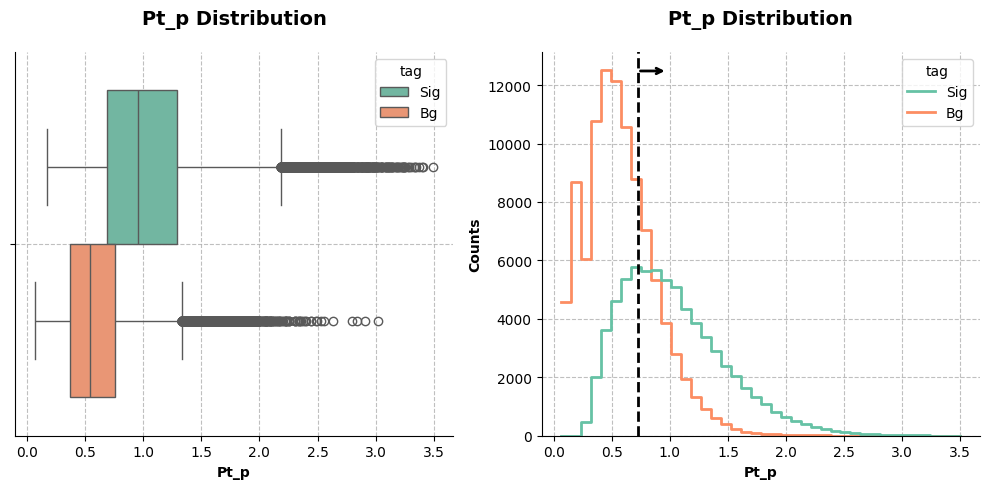

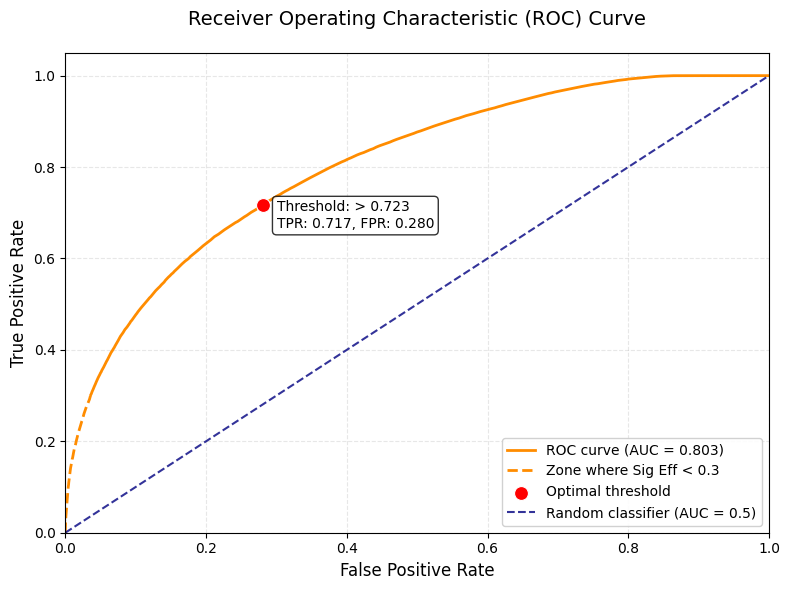

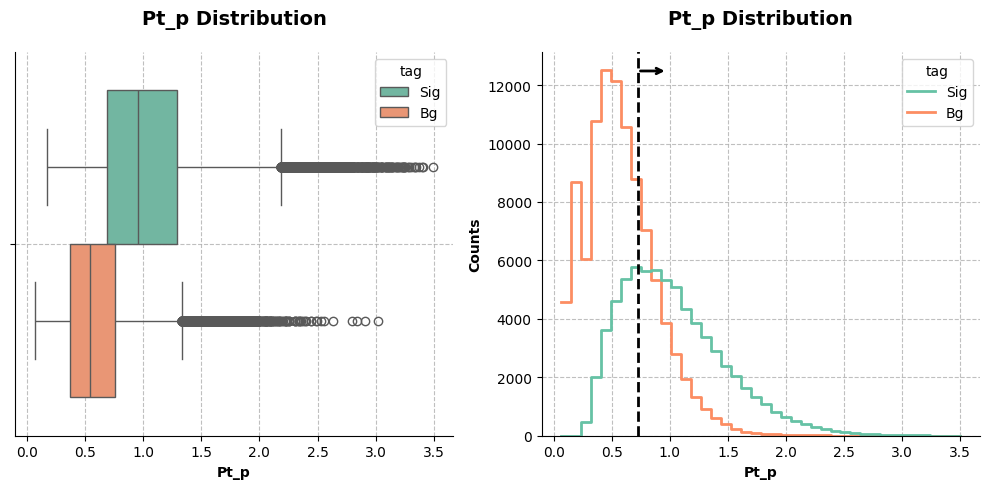

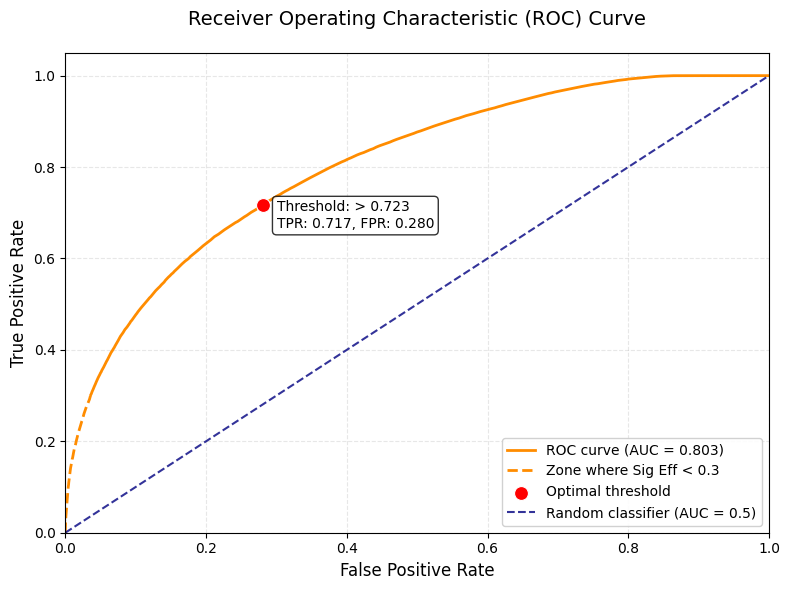

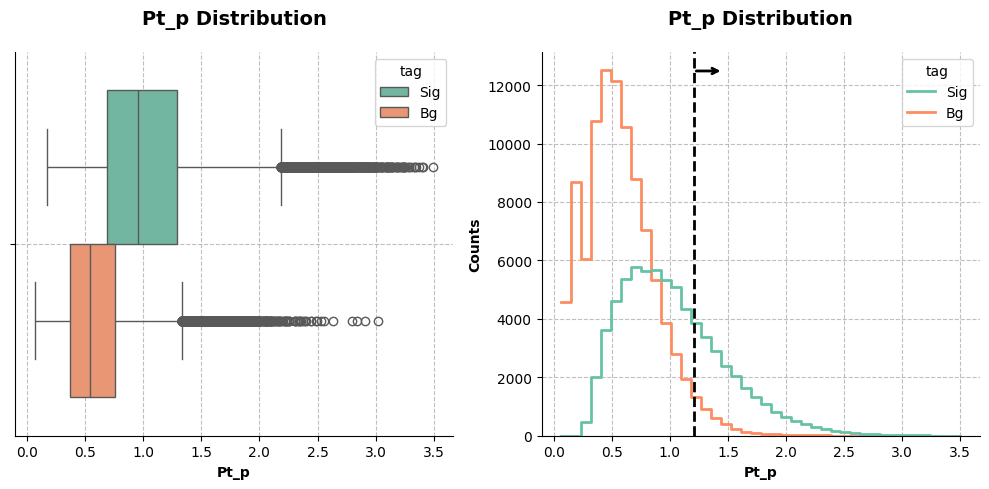

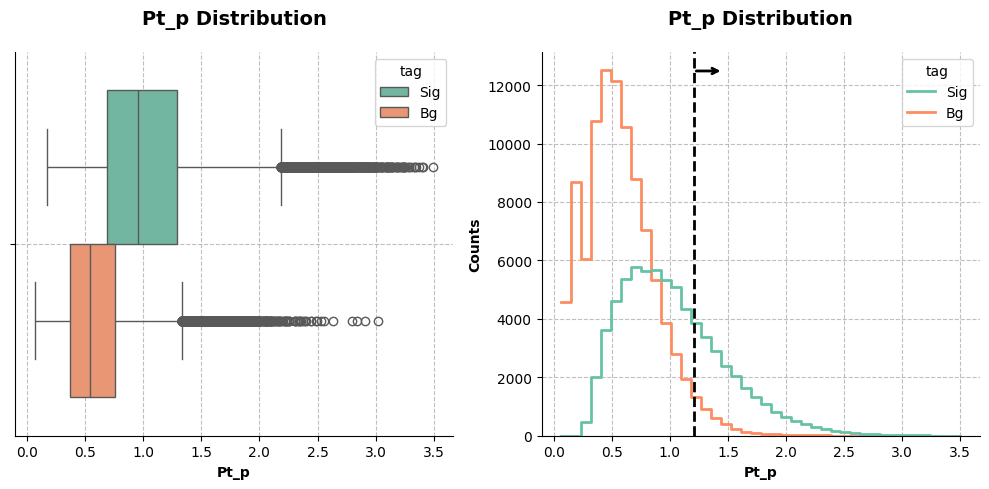

In [6]:
from scripts import draw_feature_distribution
from scripts import draw_roc
from scripts import find_optimal_cut_point

feature = 'Pt_p'
select_direction = 'right'
metric_type = 'tpr_fpr'
bounds = None
min_sig_sel = 0.3
temp_df = proc_df.copy()



min_sig_sel_mask, best_arg, metric_1, metric_2, thresholds, sig_efficiency, bg_efficiency = find_optimal_cut_point(
    df=proc_df[['mass_Lc', 'tag', feature]],
    feature=feature,
    bounds=bounds,
    select_direction=select_direction,
    metric_type=metric_type,
    min_sig_sel=min_sig_sel,
    have_sig_events=2.1555 * 1e6,
    have_bg_events=39.2 * 1e6,
    mass_interval=(2.24763, 2.32497)
)

if bounds is not None:
    bounds_mask = (temp_df[feature] >= bounds[0]) & (temp_df[feature] <= bounds[1])
    temp_df = temp_df[bounds_mask]
    
best_cut_x = thresholds[min_sig_sel_mask][best_arg]
best_tpr = metric_1[min_sig_sel_mask][best_arg]
best_fpr = metric_2[min_sig_sel_mask][best_arg]

draw_feature_distribution(
    df=temp_df,
    distr_name=feature,
    tag=None,
    hue='tag',
    bins=40,
    norma=False,
    cut_point=best_cut_x,
    select_direction=select_direction
)

if metric_type not in ['significance', 'ratio']:
    
    _ = draw_roc(
        tpr=metric_1,
        fpr=metric_2,
        best_cut_x=best_cut_x,
        best_tpr=best_tpr,
        best_fpr=best_fpr,
        select_direction=select_direction,
        mask=min_sig_sel_mask,
        min_sig_sel=min_sig_sel
    )
    
feature = 'Pt_p'
select_direction = 'right'
metric_type = 'efficiency'
bounds = None
min_sig_sel = 0.3
temp_df = proc_df.copy()



min_sig_sel_mask, best_arg, metric_1, metric_2, thresholds, sig_efficiency, bg_efficiency = find_optimal_cut_point(
    df=proc_df[['mass_Lc', 'tag', feature]],
    feature=feature,
    bounds=bounds,
    select_direction=select_direction,
    metric_type=metric_type,
    min_sig_sel=min_sig_sel,
    have_sig_events=2.1555 * 1e6,
    have_bg_events=39.2 * 1e6,
    mass_interval=(2.24763, 2.32497)
)

if bounds is not None:
    bounds_mask = (temp_df[feature] >= bounds[0]) & (temp_df[feature] <= bounds[1])
    temp_df = temp_df[bounds_mask]
    
best_cut_x = thresholds[min_sig_sel_mask][best_arg]
best_tpr = metric_1[min_sig_sel_mask][best_arg]
best_fpr = metric_2[min_sig_sel_mask][best_arg]

draw_feature_distribution(
    df=temp_df,
    distr_name=feature,
    tag=None,
    hue='tag',
    bins=40,
    norma=False,
    cut_point=best_cut_x,
    select_direction=select_direction
)

if metric_type not in ['significance', 'ratio']:
    
    _ = draw_roc(
        tpr=metric_1,
        fpr=metric_2,
        best_cut_x=best_cut_x,
        best_tpr=best_tpr,
        best_fpr=best_fpr,
        select_direction=select_direction,
        mask=min_sig_sel_mask,
        min_sig_sel=min_sig_sel
    )
    
feature = 'Pt_p'
select_direction = 'right'
metric_type = 'significance'
bounds = None
min_sig_sel = 0.3
temp_df = proc_df.copy()



min_sig_sel_mask, best_arg, metric_1, metric_2, thresholds, sig_efficiency, bg_efficiency = find_optimal_cut_point(
    df=proc_df[['mass_Lc', 'tag', feature]],
    feature=feature,
    bounds=bounds,
    select_direction=select_direction,
    metric_type=metric_type,
    min_sig_sel=min_sig_sel,
    have_sig_events=2.1555 * 1e6,
    have_bg_events=39.2 * 1e6,
    mass_interval=(2.24763, 2.32497)
)

if bounds is not None:
    bounds_mask = (temp_df[feature] >= bounds[0]) & (temp_df[feature] <= bounds[1])
    temp_df = temp_df[bounds_mask]
    
best_cut_x = thresholds[min_sig_sel_mask][best_arg]
best_tpr = metric_1[min_sig_sel_mask][best_arg]
best_fpr = metric_2[min_sig_sel_mask][best_arg]

draw_feature_distribution(
    df=temp_df,
    distr_name=feature,
    tag=None,
    hue='tag',
    bins=40,
    norma=False,
    cut_point=best_cut_x,
    select_direction=select_direction
)

if metric_type not in ['significance', 'ratio']:
    
    _ = draw_roc(
        tpr=metric_1,
        fpr=metric_2,
        best_cut_x=best_cut_x,
        best_tpr=best_tpr,
        best_fpr=best_fpr,
        select_direction=select_direction,
        mask=min_sig_sel_mask,
        min_sig_sel=min_sig_sel
    )
    
    
feature = 'Pt_p'
select_direction = 'right'
metric_type = 'ratio'
bounds = None
min_sig_sel = 0.3
temp_df = proc_df.copy()



min_sig_sel_mask, best_arg, metric_1, metric_2, thresholds, sig_efficiency, bg_efficiency = find_optimal_cut_point(
    df=proc_df[['mass_Lc', 'tag', feature]],
    feature=feature,
    bounds=bounds,
    select_direction=select_direction,
    metric_type=metric_type,
    min_sig_sel=min_sig_sel,
    have_sig_events=2.1555 * 1e6,
    have_bg_events=39.2 * 1e6,
    mass_interval=(2.24763, 2.32497)
)

if bounds is not None:
    bounds_mask = (temp_df[feature] >= bounds[0]) & (temp_df[feature] <= bounds[1])
    temp_df = temp_df[bounds_mask]
    
best_cut_x = thresholds[min_sig_sel_mask][best_arg]
best_tpr = metric_1[min_sig_sel_mask][best_arg]
best_fpr = metric_2[min_sig_sel_mask][best_arg]

draw_feature_distribution(
    df=temp_df,
    distr_name=feature,
    tag=None,
    hue='tag',
    bins=40,
    norma=False,
    cut_point=best_cut_x,
    select_direction=select_direction
)

if metric_type not in ['significance', 'ratio']:
    
    _ = draw_roc(
        tpr=metric_1,
        fpr=metric_2,
        best_cut_x=best_cut_x,
        best_tpr=best_tpr,
        best_fpr=best_fpr,
        select_direction=select_direction,
        mask=min_sig_sel_mask,
        min_sig_sel=min_sig_sel
    )

In [6]:
from scripts import calculate_feature_importance


features=['Pt_p', 'Pt_K', 'Pt_pip']

# features = ['Pt_p']


calculate_feature_importance(
    df=proc_df[['mass_Lc', 'tag']+features],
    features=features,
    direction_restrictions=None,
    metric_type='tpr_fpr',
    have_sig_events=2.1555 * 1e6,
    have_bg_events=39.2 * 1e6,
    mass_interval=(2.24763, 2.32497)
)

****************************************
Progress: 1/3
Process feature: Pt_p
Cut point search progress: 0/1000
Cut point search progress: 200/1000
Cut point search progress: 400/1000
Cut point search progress: 600/1000
Cut point search progress: 800/1000
tpr_fpr value: 0.1316, direction: left
Cut point search progress: 0/1000
Cut point search progress: 200/1000
Cut point search progress: 400/1000
Cut point search progress: 600/1000
Cut point search progress: 800/1000
tpr_fpr value: 0.7952, direction: right
****************************************
Progress: 2/3
Process feature: Pt_K
Cut point search progress: 0/1000
Cut point search progress: 200/1000
Cut point search progress: 400/1000
Cut point search progress: 600/1000
Cut point search progress: 800/1000
tpr_fpr value: 0.1503, direction: left
Cut point search progress: 0/1000
Cut point search progress: 200/1000
Cut point search progress: 400/1000
Cut point search progress: 600/1000
Cut point search progress: 800/1000
tpr_fpr value: 0

,metric,feature,feature_sel_direction,cut,signal_efficiency,background_efficiency
0,0.795191,Pt_p,right,0.722687,0.717348,0.280308
1,0.771662,Pt_K,right,0.677960,0.644302,0.239732
2,0.553270,Pt_pip,right,0.413741,0.534918,0.417395


In [7]:
from scripts import create_best_selection_path


features = ['Pt_p', 'Pt_K', 'Pt_pip']


result_df = create_best_selection_path(
    proc_df[['mass_Lc', 'tag']+features],
    features=features, 
    n_features_to_use=2, 
    metric_type='tpr_fpr',
    have_sig_events=2.1555 * 1e6,
    have_bg_events=39.2 * 1e6,
    mass_interval=(2.24763, 2.32497),
    direction_restrictions=None
)

Selection Progress: 1/2
Remaining features: 3
Remaining events - Signal: 70065, Background: 99098
****************************************
Progress: 1/3
Process feature: Pt_p
Cut point search progress: 0/1000
Cut point search progress: 200/1000
Cut point search progress: 400/1000
Cut point search progress: 600/1000
Cut point search progress: 800/1000
tpr_fpr value: 0.1316, direction: left
Cut point search progress: 0/1000
Cut point search progress: 200/1000
Cut point search progress: 400/1000
Cut point search progress: 600/1000
Cut point search progress: 800/1000
tpr_fpr value: 0.7952, direction: right
****************************************
Progress: 2/3
Process feature: Pt_K
Cut point search progress: 0/1000
Cut point search progress: 200/1000
Cut point search progress: 400/1000
Cut point search progress: 600/1000
Cut point search progress: 800/1000
tpr_fpr value: 0.1503, direction: left
Cut point search progress: 0/1000
Cut point search progress: 200/1000
Cut point search progress:

In [8]:
result_df

,selected_feature,cut_point,select_direction,signal_efficiency,background_efficiency,ratio,overall_s_sqrt_s_b,total_sig_unscaled,total_bg_unscaled
0,Pt_p,0.722687,right,0.717348,0.280308,0.000047,26.073116,70065,99098
1,Pt_K,0.586368,right,0.697817,0.257002,0.000121,35.325544,50261,27778
